In [3]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split

In [7]:
import re
import pandas as pd

train_dataset = pd.read_csv('./Corona_NLP_train.csv', encoding = "ISO-8859-1")
test_dataset = pd.read_csv('./Corona_NLP_test.csv', encoding = "ISO-8859-1")

to_drop = ['UserName', 'ScreenName', 'Location', 'TweetAt']

train_dataset = train_dataset.drop(columns=to_drop).sample(frac=1, random_state=42) # shuffle rows
test_dataset = test_dataset.drop(columns=to_drop)

def clean_text(text):
    text = text.lower()
    hashtags = "#[\S]+"
    mentions = "@[\S]+"
    url = "https?://[A-z0-9_%/\-\.]+[A-z0-9_\.\-\?&=%]+"
    text = re.sub(url,"",text)
    text = re.sub(hashtags,"",text)
    text = re.sub(mentions,"",text)
    puntuations = "[\.\?!,;:]+"
    text = re.sub(puntuations,"",text)
    return text

map = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4
}

revmap = {
    0: 'Extremely Negative',
    1: 'Negative',
    2: 'Neutral',
    3: 'Positive',
    4: 'Extremely Positive'
}

train_dataset['OriginalTweet'] = train_dataset['OriginalTweet'].apply(lambda x: clean_text(x))
test_dataset['OriginalTweet'] = test_dataset['OriginalTweet'].apply(lambda x: clean_text(x))

train_dataset['Sentiment'] = train_dataset['Sentiment'].apply(lambda x: map[x])
test_dataset['Sentiment'] = test_dataset['Sentiment'].apply(lambda x: map[x])

train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, shuffle=True)

In [9]:
import torch
from torch import nn
from prettytable import PrettyTable
from transformers import AutoModel, AutoTokenizer
from modules import Encoder, EncoderForSequenceClassification

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

class TwitterDataset(Dataset):
    def __init__(self, set) -> None:
        super(TwitterDataset, self).__init__()
        self.input = set['input_ids']
        self.labels = set['labels']
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return {
        'input_ids': self.input[index],
        'labels': self.labels[index]
    }

def dset(set):
    tweets = set['OriginalTweet'].to_list()
    tokenized = tokenizer(tweets, return_tensors='pt', padding='max_length', truncation=True, max_length=64)

    return {
        'input_ids': tokenized['input_ids'],
        'labels': ohe.fit_transform(set['Sentiment'].to_numpy().reshape(-1, 1))
    }

train_loader = DataLoader(TwitterDataset(dset(train_dataset)), batch_size=128)
val_loader = DataLoader(TwitterDataset(dset(val_dataset)), batch_size=256)
test_loader = DataLoader(TwitterDataset(dset(test_dataset)), batch_size=256)

---
## Тренировка модели

In [43]:
import torch
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam, AdamW, lr_scheduler
from sklearn.metrics import classification_report, f1_score

def train(model, train_loader, epochs, lr, val_loader = None):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = lr_scheduler.CosineAnnealingLR(
        optimizer, 25, 
    )

    model.train()
    
    losses = []
    valid = []
    pbar, step = tqdm(range(len(train_loader) * epochs)), 0
 
    for epoch in range(epochs):
        for batch in train_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            preds = model(inputs)
            loss = criterion(preds, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            losses.append(loss.item())
            pbar.set_description(f'Epoch: {epoch+1}, training loss: {loss.item():0.5f}')#, lr: {scheduler.get_last_lr()[0]:0.5f}')

            step +=1
            pbar.update(1)
        scheduler.step()
        
        validation_f1, val_loss = evaluate(model, val_loader, return_f1=True, show_progress=False)
        valid.append((validation_f1, val_loss))

    return losses, valid

def evaluate(model, loader, return_f1 = False, show_progress = True):
    pred, true = [], []

    model.eval()

    criterion = nn.CrossEntropyLoss()
    running_loss = 0
    
    if show_progress:
        pbar = tqdm(range(len(loader)), total=len(loader))
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            preds = model(inputs)
            running_loss += criterion(preds, labels).item()
            pred.extend(torch.argmax(preds.cpu(), dim=-1))
            true.extend(torch.argmax(labels.cpu(), dim=-1))
            if show_progress:
                pbar.update(1)
    
    pred = np.array(pred)
    true = np.array(true)
    
    if return_f1:
        return f1_score(true, pred, average='weighted'), running_loss / len(loader)

    return true, pred, running_loss / len(loader)

In [44]:
classifier = EncoderForSequenceClassification(
    Encoder(tokenizer.vocab_size, context=64),
    num_classes = 5
).to(device)
count_parameters(classifier)

+---------------------------------------+------------+
|                Modules                | Parameters |
+---------------------------------------+------------+
|           encoder.te.weight           |  1953408   |
|        encoder.layernorm.weight       |     64     |
|         encoder.layernorm.bias        |     64     |
| encoder.layers.0.attention.wqs.weight |    256     |
|  encoder.layers.0.attention.wqs.bias  |     4      |
| encoder.layers.0.attention.wks.weight |    256     |
|  encoder.layers.0.attention.wks.bias  |     4      |
| encoder.layers.0.attention.wvs.weight |    4096    |
|  encoder.layers.0.attention.wvs.bias  |     64     |
|  encoder.layers.0.attention.wo.weight |    4096    |
|   encoder.layers.0.attention.wo.bias  |     64     |
|    encoder.layers.0.linear1.weight    |    8192    |
|     encoder.layers.0.linear1.bias     |    128     |
|    encoder.layers.0.linear2.weight    |    8192    |
|     encoder.layers.0.linear2.bias     |     64     |
|   encode

1979405

In [45]:
true, pred, _ = evaluate(classifier, test_loader)
print(classification_report(true, pred))

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       592
           1       0.00      0.00      0.00      1041
           2       0.00      0.00      0.00       619
           3       0.25      1.00      0.40       947
           4       0.00      0.00      0.00       599

    accuracy                           0.25      3798
   macro avg       0.05      0.20      0.08      3798
weighted avg       0.06      0.25      0.10      3798



In [46]:
print(evaluate(classifier, test_loader, return_f1=True)[0])

  0%|          | 0/15 [00:00<?, ?it/s]

0.09952651026467815


In [47]:
losses, valid = train(classifier, train_loader, epochs=15, lr=1e-3, val_loader=val_loader)

  0%|          | 0/4350 [00:00<?, ?it/s]

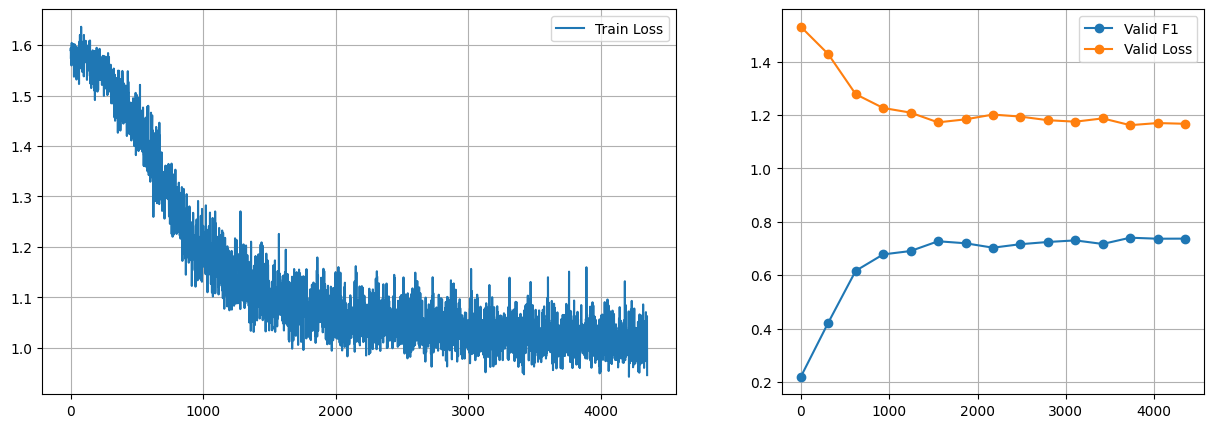

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[3, 2])
axs[0].plot(torch.arange(len(losses)), losses, label='Train Loss')
axs[0].grid()
axs[0].legend()

its = torch.linspace(0, len(losses), len(valid)).int()
axs[1].plot(its, [v[0] for v in valid], label='Valid F1', marker='o')
axs[1].plot(its, [v[1] for v in valid], label='Valid Loss', marker='o')
axs[1].grid()
axs[1].legend()
plt.show()

In [49]:
true, pred, _ = evaluate(classifier, test_loader)
print(classification_report(true, pred))

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.81      0.60      0.69       592
           1       0.63      0.71      0.67      1041
           2       0.89      0.76      0.82       619
           3       0.62      0.72      0.67       947
           4       0.78      0.71      0.75       599

    accuracy                           0.70      3798
   macro avg       0.75      0.70      0.72      3798
weighted avg       0.72      0.70      0.71      3798



In [50]:
print(evaluate(classifier, test_loader, return_f1=True)[0])

  0%|          | 0/15 [00:00<?, ?it/s]

0.7071113150649598


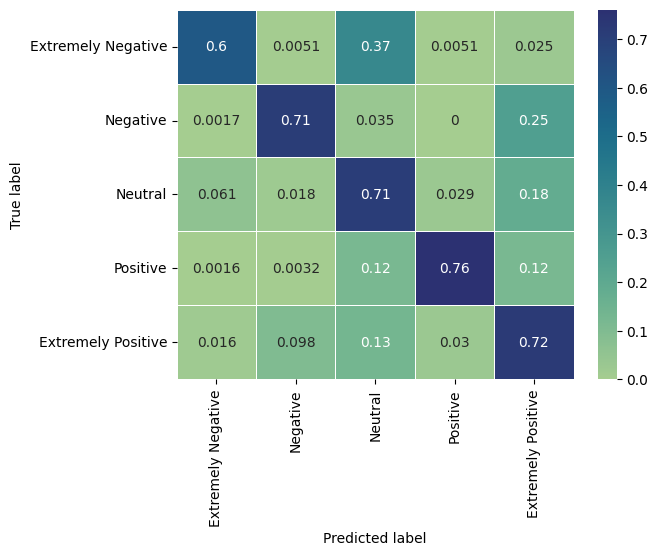

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix([revmap[x] for x in true], [revmap[x] for x in pred])
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True, linewidth=.5, cmap="crest", 
            xticklabels=revmap.values(), yticklabels=revmap.values())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()